In [1]:
!pip install EMD-signal
!pip install vnstock

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.6/74.6 kB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.2 MB/s eta 0:00:00
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.66.1
    Uninstalling tqdm-4.66.1:
      Successfully uninstalled tqdm-4.66.1


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import PyEMD as pe
from vnstock import *

Observations:  1639
             Open   High    Low  Close   Volume Ticker
Time                                                  
2017-06-02  10590  11040  10510  10950  5519180    SSI
2017-06-05  11000  11040  10740  10740  2811740    SSI
2017-06-06  10800  10910  10720  10870  2952940    SSI
2017-06-07  10950  11140  10930  10980  4110110    SSI
2017-06-08  11040  11210  10930  11060  3599060    SSI
2017-06-09  11120  11300  11080  11140  3427850    SSI


<Axes: xlabel='Time'>

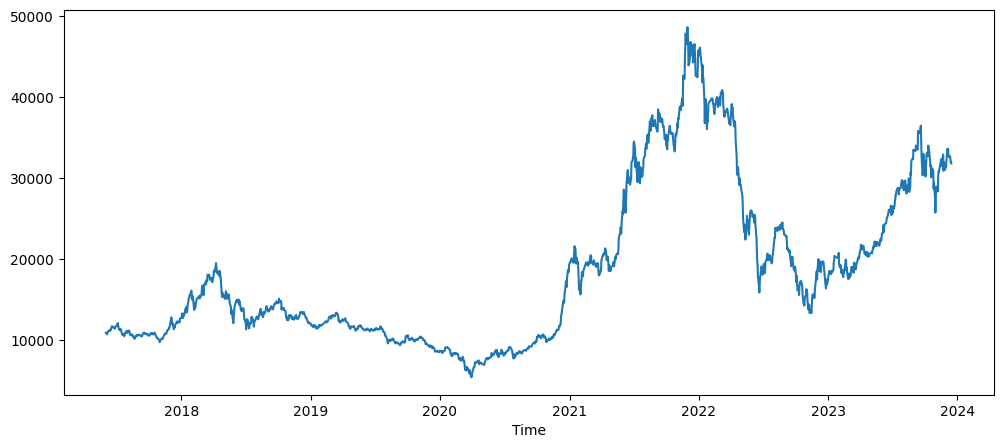

In [3]:
# Import data
SSI = stock_historical_data(symbol = "SSI", start_date="2017-06-01", end_date="2023-12-15", resolution="1D", type = "stock", beautify=True, decor=True, source = "DNSE")
from matplotlib import pyplot
print("Observations: ",len(SSI['Close']))
print(pd.DataFrame(SSI.head(6)))
train_dates = SSI.index
plt.figure(figsize=(12, 5))
SSI["Close"].plot()

In [4]:
SSI = SSI.reset_index(drop = True)
df = SSI['Close']
df

0       10950
1       10740
2       10870
3       10980
4       11060
        ...  
1634    32700
1635    32600
1636    32000
1637    32000
1638    31800
Name: Close, Length: 1639, dtype: int64

In [5]:
## (A) CEEMDAN
#### 1. Thêm white noise vào chuỗi gốc s(t) thành chuỗi s1(t)
#### 2. Decompose chuỗi s1(t) bằng EMD ra các chuỗi IMF1 và Residue1
#### 3. Trung bình các chuỗi IMF1(t) thành mIMF1(t)
#### 4. r1(t) = s1(t) - mIMF1(t)
#### 5. Chuỗi mới s2(t) = r1(t) + coef*EMD(noise)
#### 6. Làm lại từ 1->5 đến khi chuỗi residue dừng

In [6]:
from PyEMD import EMD, CEEMDAN

In [7]:
ceemdan = CEEMDAN(range_thr=0.001, total_power_thr=0.01)
cIMFs = ceemdan.ceemdan(S=np.array(df.values), T= np.array(df.index))

In [8]:
pd.DataFrame(cIMFs.T, columns = ["IMF"+str(i+1) for i in range(cIMFs.shape[0])])

,IMF1,IMF2,IMF3,IMF4,IMF5,IMF6,IMF7
0,58.987052,-6.694975,-576.794504,216.825627,1732.084994,-2316.216638,11841.808444
1,-85.318081,-63.052093,-588.146317,214.658916,1735.556558,-2316.069321,11842.370338
2,-2.095499,-35.361108,-570.617137,212.487444,1737.859278,-2315.199459,11842.926481
3,26.113879,3.671934,-528.935550,210.307136,1738.966737,-2313.600923,11843.476787
4,-4.316937,54.809047,-470.200182,208.098641,1738.856038,-2311.267956,11844.021349
...,...,...,...,...,...,...,...
1634,72.412297,-449.182697,74.039367,2415.615880,14740.441688,-15322.113734,31168.787197
1635,148.911134,-494.194849,-87.246859,2454.816883,14703.410630,-15292.729396,31167.032458
1636,-140.904389,-674.015161,-215.153879,2458.821422,14668.958528,-15262.941153,31165.234632
1637,125.032765,-837.557237,-277.716747,2422.537063,14637.061618,-15232.751227,31163.393764


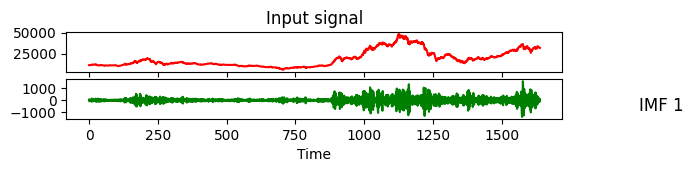

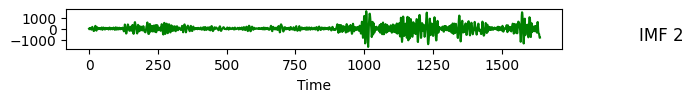

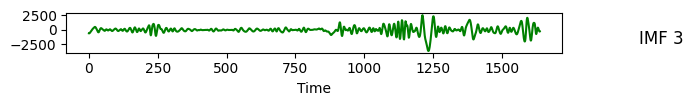

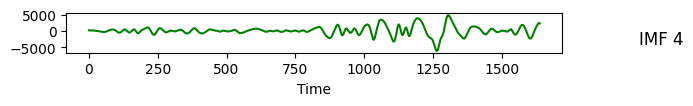

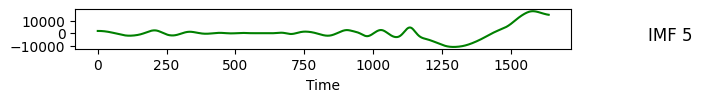

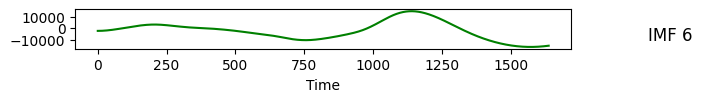

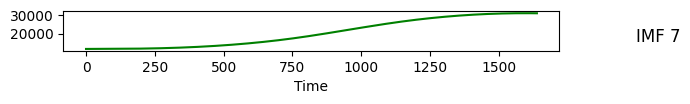

In [9]:
N = cIMFs.shape[0]+1
# Plot results
plt.subplot(N,1,1)
plt.plot(df.index, df.values, 'r')
plt.title("Input signal")
plt.xlabel("Time")

for n, imf in enumerate(cIMFs):
  plt.subplot(N,1,n+2)
  plt.plot(df.index, imf, 'g')
  plt.title("IMF "+str(n+1), x=1.2, y = 0)
  plt.xlabel("Time")
  plt.show()

In [10]:
# Tính residue
scIMF = cIMFs.sum(axis = 0).reshape(-1, 1)
residue = (np.array(df)-cIMFs.sum(axis = 0)).reshape(-1,1)

print("sIMF:", scIMF.shape)
print("Residue:", residue.shape)

sIMF: (1639, 1)
Residue: (1639, 1)


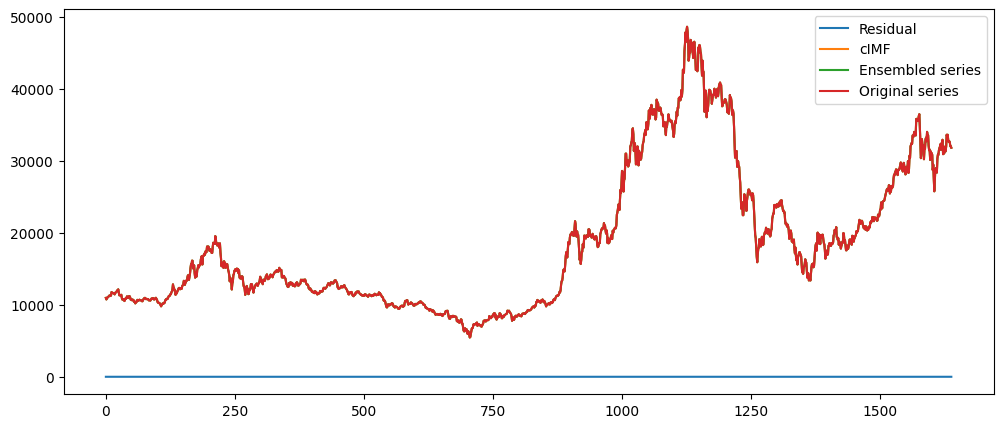

In [11]:
plt.figure(figsize=(12,5))
plt.plot(range(0,len(df)), residue)
plt.plot(range(0,len(df)), scIMF)
plt.plot(range(0,len(df)), scIMF+residue)
plt.plot(df)
plt.legend(["Residual", "cIMF", "Ensembled series", "Original series"])

plt.show()

In [12]:
# (B) LSTM
## 0. Prepocessing
# load các thư viện cần thiết
import math
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import seaborn as sns
from sklearn.model_selection import KFold, cross_val_predict, train_test_split,GridSearchCV,cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder,StandardScaler,PowerTransformer, MinMaxScaler, RobustScaler

In [13]:
cIMF = cIMFs.sum(axis = 0).reshape(-1, 1)+residue
cIMF

array([[10950.],
       [10740.],
       [10870.],
       ...,
       [32000.],
       [32000.],
       [31800.]])

In [14]:
# Scale data to 0-1
scaler = StandardScaler()
def Scaling (data):
    IMFscale = scaler.fit_transform(np.array(data))

    return IMFscale
IMFscale = Scaling(cIMF)
#train_scaled = scaler.inverse_transform(train_scaled)
#pd.DataFrame(train_scaled, columns=["IMF"+str(i+1) for i in range(cIMFs.shape[0])])

(1639, 1)
Train:  (983, 1)
Test:  (656, 1)


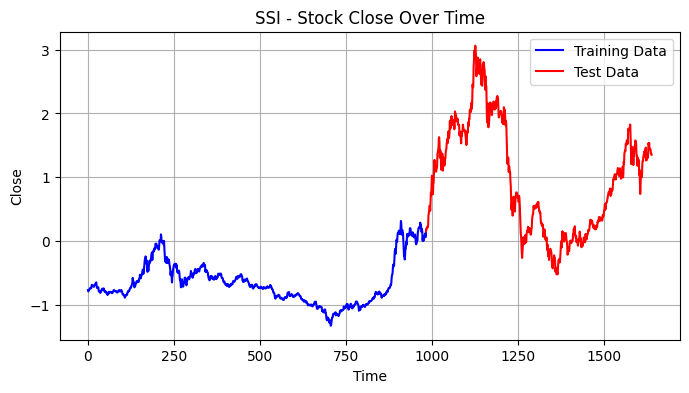

In [15]:
print(IMFscale.shape)
# Chia train test
train_size = int(0.6*IMFscale.shape[0])
test_size = int(0.4*IMFscale.shape[0])
train_data = IMFscale[:train_size].reshape(-1,1)
test_data = IMFscale[train_size:].reshape(-1,1)

print("Train: ", train_data.shape)
print("Test: ", test_data.shape)

# Plotting both training and test data on the same chart
plt.figure(figsize=(8, 4))

plt.plot(range(train_size), train_data, linestyle='-', color='b', label='Training Data')
plt.plot(range(train_size -1,  train_size+test_size), test_data, linestyle='-',  color='r', label='Test Data')


plt.title('SSI - Stock Close Over Time')
plt.xlabel('Time')
plt.ylabel('Close')
plt.legend()
plt.grid(True)
plt.show()

In [16]:
trainX = []
trainY = []

n_past = 60
n_future = 1

for i in range(n_past, len(train_data) - n_future + 1):
    past_sequence = train_data[i - n_past:i, 0:train_data.shape[1]]  # Exclude the first column ("Close") for trainX
    future_sequence = train_data[i + n_future - 1: i + n_future, 0]  # Use the "Close" column for trainY

    trainX.append(past_sequence)
    trainY.append(future_sequence)

trainX, trainY = np.array(trainX), np.array(trainY)
print("X train: ", trainX.shape)
print("Y train: ", trainY.shape)

X train:  (923, 60, 1)
Y train:  (923, 1)


In [17]:
testX = []
testY = []

for i in range(n_past, len(test_data) - n_future + 1):
    past_sequence = test_data[i - n_past:i, 0:test_data.shape[1]]  # Exclude the first column ("Close") for trainX
    future_sequence = test_data[i + n_future - 1: i + n_future, 0]  # Use the "Close" column for trainY

    testX.append(past_sequence)
    testY.append(future_sequence)

testX, testY = np.array(testX), np.array(testY)

print("X test: ", testX.shape)
print("Y test: ", testY.shape)

X test:  (596, 60, 1)
Y test:  (596, 1)


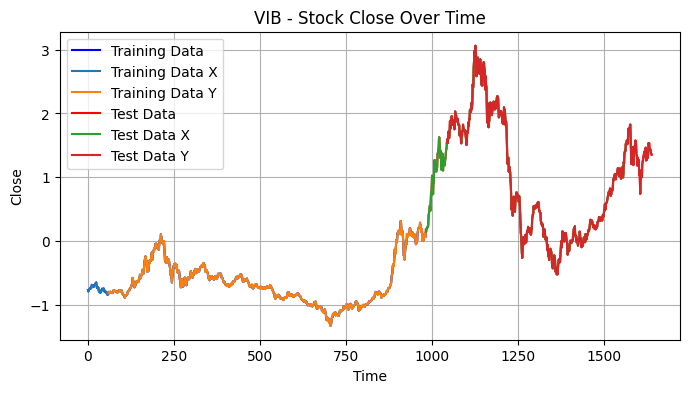

In [18]:
# Plotting both training and test data on the same chart
plt.figure(figsize=(8, 4))

plt.plot(range(train_size), train_data, linestyle='-', color='b', label='Training Data')
plt.plot(range(train_size-n_past), trainX[:,0,0], linestyle='-', label='Training Data X')
plt.plot(range(n_past,train_size), trainY[:,0], linestyle='-', label='Training Data Y')
plt.plot(range(train_size, train_size+test_size+1), test_data, linestyle='-',  color='r', label='Test Data')
plt.plot(range(train_size, train_size+test_size-n_past+1), testX[:,0,0], linestyle='-',  label='Test Data X')
plt.plot(range(train_size+n_past, train_size+test_size+1), testY[:,0], linestyle='-', label='Test Data Y')


plt.title('VIB - Stock Close Over Time')
plt.xlabel('Time')
plt.ylabel('Close')
plt.legend()

plt.show()

In [22]:
## 1. Train model
# Tạo model lstm cho việc training
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(trainX.shape[2]))
model.compile(optimizer='adam', loss='mape')
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 60, 64)            16896     
                                                                 
 lstm_5 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 29345 (114.63 KB)
Trainable params: 29345 (114.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [23]:
# fit the model
history = model.fit(trainX, trainY, epochs=60, batch_size=4, validation_split=0.2, verbose=1)

Epoch 1/60
185/185 [==============================] - 7s 26ms/step - loss: 51.7571 - val_loss: 131.3486
Epoch 2/60
185/185 [==============================] - 5s 27ms/step - loss: 31.9672 - val_loss: 103.1378
Epoch 3/60
185/185 [==============================] - 5s 25ms/step - loss: 25.8784 - val_loss: 79.9473
Epoch 4/60
185/185 [==============================] - 5s 27ms/step - loss: 27.2975 - val_loss: 95.6471
Epoch 5/60
185/185 [==============================] - 5s 25ms/step - loss: 23.7780 - val_loss: 96.3682
Epoch 6/60
185/185 [==============================] - 5s 25ms/step - loss: 23.7956 - val_loss: 99.1318
Epoch 7/60
185/185 [==============================] - 5s 26ms/step - loss: 22.3782 - val_loss: 89.1938
Epoch 8/60
185/185 [==============================] - 5s 28ms/step - loss: 21.9316 - val_loss: 77.9884
Epoch 9/60
185/185 [==============================] - 5s 27ms/step - loss: 22.8134 - val_loss: 90.2111
Epoch 10/60
185/185 [==============================] - 5s 29ms/step - l

KeyboardInterrupt: ignored

In [ ]:
prediction = model.predict(testX)
prediction_copies = np.repeat(prediction, train_data.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]
print(y_pred_future)

19/19 [==============================] - 1s 22ms/step
[ 2.16062549e+03  9.08292285e+03  1.43729277e+04  1.46411201e+04
  1.68031387e+04  1.65142617e+04  1.69506309e+04  1.75796953e+04
  1.89420625e+04  1.72649668e+04  1.74998730e+04  1.89552793e+04
  1.88760645e+04  8.37944238e+03  1.59707373e+04  1.65137461e+04
  1.75831660e+04 -1.67306465e+04  1.74879043e+04 -3.13638037e+03
 -1.37732656e+04 -6.02486670e+03  1.52159580e+04 -2.17486660e+04
 -9.64179199e+02 -4.98059131e+03  1.71813379e+04  4.09719287e+03
  1.03567285e+04  1.46600225e+04 -1.84984156e+05 -1.68887281e+05
 -1.52807594e+05  1.81651035e+04  1.83325918e+04  1.68683867e+04
  1.49557344e+04 -1.03384824e+04  1.64792441e+04 -7.64586475e+03
 -1.74469500e+05 -2.21568453e+05  1.67360352e+04  1.70521484e+04
  1.70016758e+04 -1.55130344e+05 -1.31268115e+03 -1.54366422e+05
  1.74394219e+04 -1.64311125e+05 -1.56133547e+05 -1.86127168e+04
 -9.50630859e+04 -1.94360516e+05 -1.90586016e+05 -1.95317312e+05
  1.98977168e+04  2.06907246e+04  2.

In [ ]:
train_back = scaler.inverse_transform(train_data)
test_back = scaler.inverse_transform(test_data)

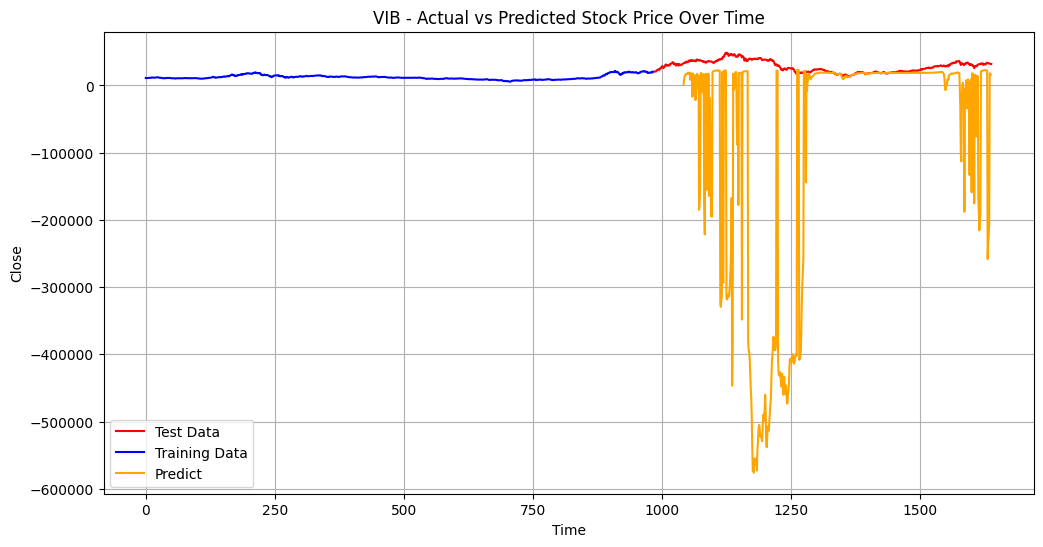

In [ ]:
plt.figure(figsize=(12, 6))
n_future = 60

# Plot actual values
plt.plot(range(train_size, train_size+test_size+1),test_back.reshape(-1,1), linestyle='-',  color='r', label='Test Data')
plt.plot(range(train_size), train_back, linestyle='-', color='b', label='Training Data')
#predict_date = Test_data['Time'];
plt.plot(range(train_size+n_future-1, train_size+test_size),  y_pred_future, label='Predict', linestyle='-',  color='orange')
# # Plot predicted values
#plt.plot( test_Date, y_pred, label='Predicted', linestyle='-',  color='b')

plt.title('VIB - Actual vs Predicted Stock Price Over Time')
plt.xlabel('Time')
plt.ylabel('Close')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
n_past = 1
n_days_for_prediction= 60

#print(test_data.reshape(1,-1).T.shape)

test_for_forecast = test_data.reshape(1,-1).T

x_forecast = []
y_forecast = []

for i in range(n_days_for_prediction):
  # B1 Duyệt dữ liệu test n ngày gần nhất => bỏ vào x tạm
  x = np.array(test_for_forecast[(-60):])
  print(x.shape)
  x = x.T.reshape(x.shape[1], x.shape[0], 1)
  print(x.shape)

  # B2 dùng predict để chạy 1 ngày
  y = model.predict(x)
  # B3 thêm data ngày đó vào y_forecast, test_for_forecast và append x vào x_forecast
  y_c = np.repeat(y, x.shape[1], axis=-1)
  y_pr = scaler.inverse_transform(y_c)[:,0]

  x_forecast.append(x)
  y_forecast.append(y_pr)
  test_for_forecast = np.append(test_for_forecast, y).reshape(-1,1)
  print(test_for_forecast.shape)
  #test_for_forecast.append(y)
  # B4 lặp lại đến ngày thứ 60

x_forecast = np.array(x_forecast)
y_forecast = np.array(y_forecast)

(60, 1)
(1, 60, 1)
1/1 [==============================] - 0s 101ms/step
(657, 1)
(60, 1)
(1, 60, 1)
1/1 [==============================] - 0s 28ms/step
(658, 1)
(60, 1)
(1, 60, 1)
1/1 [==============================] - 0s 26ms/step
(659, 1)
(60, 1)
(1, 60, 1)
1/1 [==============================] - 0s 26ms/step
(660, 1)
(60, 1)
(1, 60, 1)
1/1 [==============================] - 0s 24ms/step
(661, 1)
(60, 1)
(1, 60, 1)
1/1 [==============================] - 0s 25ms/step
(662, 1)
(60, 1)
(1, 60, 1)
1/1 [==============================] - 0s 25ms/step
(663, 1)
(60, 1)
(1, 60, 1)
1/1 [==============================] - 0s 26ms/step
(664, 1)
(60, 1)
(1, 60, 1)
1/1 [==============================] - 0s 27ms/step
(665, 1)
(60, 1)
(1, 60, 1)
1/1 [==============================] - 0s 35ms/step
(666, 1)
(60, 1)
(1, 60, 1)
1/1 [==============================] - 0s 27ms/step
(667, 1)
(60, 1)
(1, 60, 1)
1/1 [==============================] - 0s 29ms/step
(668, 1)
(60, 1)
(1, 60, 1)
1/1 [===============

In [ ]:
print(y_forecast)

[[ 1.44910117e+04]
 [ 1.58697148e+04]
 [ 1.99189277e+04]
 [-2.47033547e+05]
 [-1.79154150e+06]
 [-9.10804700e+06]
 [-2.84072320e+07]
 [-7.59193600e+07]
 [-1.89830448e+08]
 [-4.67016448e+08]
 [-1.08191283e+09]
 [-2.61256934e+09]
 [-6.01313997e+09]
 [-1.35854776e+10]
 [-3.04438600e+10]
 [-6.83301233e+10]
 [-1.53383830e+11]
 [-3.44344920e+11]
 [-7.73074387e+11]
 [-1.73561532e+12]
 [-3.89661118e+12]
 [-8.74825174e+12]
 [-1.96406443e+13]
 [-4.40950912e+13]
 [-9.89976372e+13]
 [-2.22259038e+14]
 [-4.98992522e+14]
 [-1.12028524e+15]
 [-2.51514600e+15]
 [-5.64674007e+15]
 [-1.26774646e+16]
 [-2.84621062e+16]
 [-6.39001154e+16]
 [-1.43461795e+17]
 [-3.22085267e+17]
 [-7.23111827e+17]
 [-1.62345434e+18]
 [-3.64480793e+18]
 [-8.18293717e+18]
 [-1.83714682e+19]
 [-4.12456850e+19]
 [-9.26004735e+19]
 [-2.07896837e+20]
 [-4.66748034e+20]
 [-1.04789334e+21]
 [-2.35261937e+21]
 [-5.28185261e+21]
 [-1.18582570e+22]
 [-2.66229053e+22]
 [-5.97709456e+22]
 [-1.34191434e+23]
 [-3.01272512e+23]
 [-6.7638539

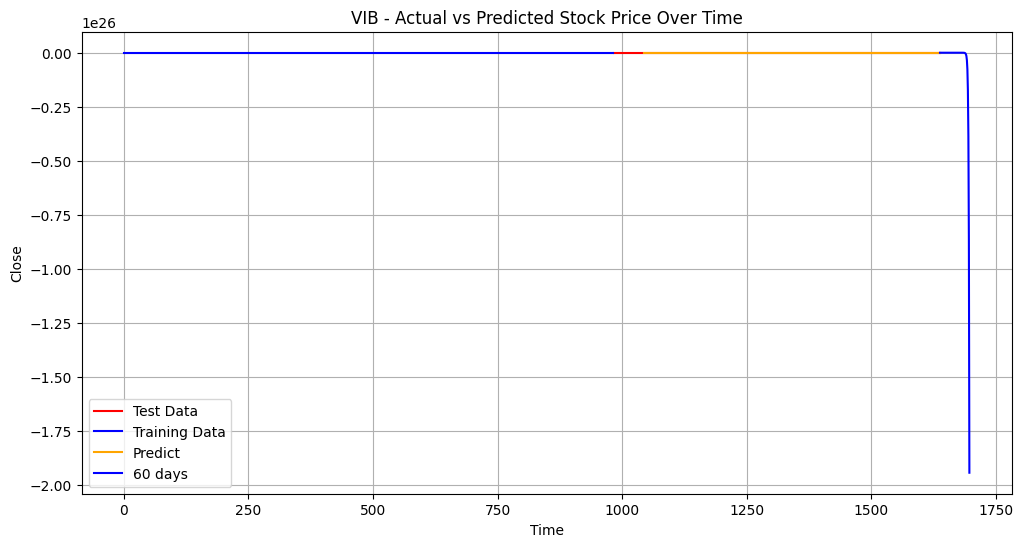

In [ ]:
plt.figure(figsize=(12, 6))

# Plot actual values
plt.plot(range(train_size, train_size+test_size+1),test_back.reshape(-1,1), linestyle='-',  color='r', label='Test Data')
plt.plot(range(train_size), train_back, linestyle='-', color='b', label='Training Data')
# Plot predict test and actual test
plt.plot(range(train_size + 60, train_size + test_size+1),  y_pred_future, label='Predict', linestyle='-',  color='orange')
# Plot 60 days
plt.plot(range(train_size+test_size, train_size+test_size+60), y_forecast, linestyle='-', color='b', label='60 days')

plt.title('VIB - Actual vs Predicted Stock Price Over Time')
plt.xlabel('Time')
plt.ylabel('Close')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
def RSME (data1, data2):
    return np.sqrt(np.mean((data1-data2)*(data1-data2)))
def MAE (data1, data2):
    return np.mean(np.absolute(data1-data2))
def MAPE (pred, actual):
    return np.mean(np.absolute((pred-actual)/actual))*100

In [ ]:
print("RSME: ", RSME(y_pred_future, test_back[-60:]))
print("MAE: ", MAE(y_pred_future, test_back[-60:]))
print("MAPE: ", MAPE(y_pred_future, test_back[-60:]))

RSME:  216489.74838573986
MAE:  116117.30326359042
MAPE:  370.8781501974605


In [ ]:
def MSLE (pred, actual):
    return np.mean((np.log(1+actual)-np.log(1+pred))*(np.log(1+actual)-np.log(1+pred)))
print("MSLR: ", MSLE(y_pred_future, test_back[14:]))

MSLR:  nan


<ipython-input-29-0f0cd95f520c>:2: RuntimeWarning: invalid value encountered in log
  return np.mean((np.log(1+actual)-np.log(1+pred))*(np.log(1+actual)-np.log(1+pred)))
